# Part 1. Anomaly Detection

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd, optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image
from tensorboardX import SummaryWriter

import numpy as np
import matplotlib.pyplot as plt
import random

torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.determinstic = False

writer = SummaryWriter(logdir='runs/GAN_training')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def imshow_grid(img):
    img = torchvision.utils.make_grid(img.cpu().detach())
    img_numpy = img.numpy()
    print(img_numpy.shape)
    plt.figure(figsize=(10, 20))
    plt.imshow(np.transpose(img_numpy, (1, 2, 0)))
    plt.show()

# GAN

# 1. Model Architecture

## 1-1. Generator

In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, ngf = 28, channels=1, bias = True):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, ngf*4, kernel_size=4, stride=1, padding=0, bias=bias),
            nn.BatchNorm2d(ngf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(ngf*4, ngf*2, kernel_size=4, stride=2, padding=1, bias=bias),
            nn.BatchNorm2d(ngf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(ngf*2, ngf, kernel_size=4, stride=2, padding=1, bias=bias),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(ngf, channels, kernel_size=4, stride=2, padding=3, bias=bias),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

## 1-2. Discriminator

In [4]:
class Discriminator(nn.Module):
    def __init__(self, ndf=28, channels=1, bias=True):
        super().__init__()
        
        def discriminator_block(in_features, out_features, bn=True):
            if bn:
                block = [
                         nn.Conv2d(in_features, out_features, 4, 2, 1, bias=bias),
                         nn.BatchNorm2d(out_features),
                         nn.LeakyReLU(0.2, inplace=True)
                ]
            else:
                block = [
                         nn.Conv2d(in_features, out_features, 4, 2, 3, bias=bias),
                         nn.LeakyReLU(0.2, inplace=True)
                ]
            return block

        self.features = nn.Sequential(
            *discriminator_block(channels, ndf, bn=False),
            *discriminator_block(ndf, ndf*2, bn=True),
            *discriminator_block(ndf*2, ndf*4, bn=True)
        )

        self.last_layer = nn.Sequential(
            nn.Conv2d(ndf*4, 1, 4, 1, 0, bias=bias),
            nn.Sigmoid()
        )

    def forward_features(self, x):
        features = self.features(x)
        return features

    def forward(self, x):
        features = self.forward_features(x)
        validity = self.last_layer(features)
        return validity

## 1-3. Encoder

In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=100, ndf=28, channels=1, bias=True):
        super().__init__()
        
        def encoder_block(in_features, out_features, bn=True):
            if bn:
                block = [
                         nn.Conv2d(in_features, out_features, 4, 2, 1, bias=bias),
                         nn.BatchNorm2d(out_features),
                         nn.LeakyReLU(0.2, inplace=True)
                ]
            else:
                block = [
                         nn.Conv2d(in_features, out_features, 4, 2, 3, bias=bias),
                         nn.LeakyReLU(0.2, inplace=True)
                ]
            return block

        self.features = nn.Sequential(
            *encoder_block(channels, ndf, bn=False),
            *encoder_block(ndf, ndf*2, bn=True),
            *encoder_block(ndf*2, ndf*4, bn=True),
            nn.Conv2d(ndf*4, latent_dim, 4, 1, 0, bias=bias),
            nn.Tanh()
        )

    def forward(self, x):
        validity = self.features(x)
        return validity

# 2. Hyperparameters

In [6]:
n_epochs = 200
batch_size = 64
lr = 0.0002
ndf = 28
ngf = 28
latent_dim = 100
img_size = 28
channels = 1
n_critic = 5
sample_interval = 400
training_label = 0
split_rate = 0.8
lambda_gp = 10

# 3. Data Preprocessing

In [7]:
class SimpleDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.transform = transform
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        labels = self.labels[idx]

        if self.transform:
            data = self.transform(data)

        return data, labels

## 3-2. Load Training Data

In [9]:
# Train Data
train_dataset = MNIST('./', train=True, download=True)

#_x_train = train_dataset.data[train_dataset.targets == 1]
_x_train = train_dataset.data
x_train, x_test_normal = _x_train.split((int(len(_x_train) * split_rate)), dim=0)

#_y_train = train_dataset.targets[train_dataset.targets == 1]
_y_train = train_dataset.targets
y_train, y_test_normal = _y_train.split((int(len(_y_train) * split_rate)), dim=0)

train_mnist = SimpleDataset(_x_train, _y_train,
                                transform=transforms.Compose(
                                    [transforms.ToPILImage(),
                                     transforms.ToTensor(),
                                     ])
                                )
train_dataloader = DataLoader(train_mnist, batch_size=batch_size, shuffle=True)

0it [00:00, ?it/s]

9920512it [05:03, 31672.28it/s]                             

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



0it [00:00, ?it/s]


  0%|          | 0/28881 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




  0%|          | 0/1648877 [00:00<?, ?it/s]

  1%|          | 16384/1648877 [00:00<00:25, 64629.10it/s]

  1%|▏         | 24576/1648877 [00:00<00:35, 45131.70it/s]

  2%|▏         | 32768/1648877 [00:01<00:41, 39182.78it/s]

  2%|▏         | 40960/1648877 [00:01<00:43, 36875.04it/s]

  3%|▎         | 49152/1648877 [00:01<00:45, 35212.60it/s]

  3%|▎         | 57344/1648877 [00:01<00:46, 34038.19it/s]

  4%|▍         | 65536/1648877 [00:02<00:47, 33380.60it/s]

  4%|▍         | 73728/1648877 [00:02<00:47, 32873.23it/s]

  5%|▍         | 81920/1648877 [00:02<00:47, 32656.12it/s]

  5%|▌         | 90112/1648877 [00:02<00:48, 32451.26it/s]

  6%|▌         | 98304/1648877 [00:03<00:48, 32254.11it/s]

  6%|▋         | 106496/1648877 [00:03<00:47, 32211.36it/s]

  7%|▋         | 114688/1648877 [00:03<00:47, 32078.61it/s]

  7%|▋         | 122880/1648877 [00:03<00:47, 32093.69it/s]

  8%|▊         | 131072/1648877 [00:04<00:47, 32050.46it/s]

  8%|▊         | 139264/1648877 [00:04<00:47, 320

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw





  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


# 4. DCGAN

## 4-1. optimizer

### 4-1-1. Weight Initialization

In [11]:
G = Generator(latent_dim = latent_dim, ngf=ngf, channels=channels, bias=True).to(device)
D = Discriminator(ndf=ndf, channels=channels, bias=True).to(device)

optimizer_G = optim.Adam(G.parameters(), lr=lr, weight_decay=1e-5)
optimizer_D = optim.Adam(D.parameters(), lr=lr, weight_decay=1e-5)

32768it [00:51, 632.61it/s]              
1654784it [00:51, 32166.49it/s]
8192it [00:00, 19084.20it/s]            


## 4-2. DCGAN Training

### 4-2-1. Training

In [12]:
padding_epoch = len(str(n_epochs)) #3
padding_i = len(str(len(train_dataloader))) # 2

d_losses = []
g_losses = []

criterion = nn.BCELoss()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(train_dataloader):
        real_imgs = imgs.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        z = torch.randn(batch_size, latent_dim, 1, 1).to(device)

        fake_imgs = G(z)

        real_validity = D(real_imgs)
        fake_validity = D(fake_imgs.detach())
        
        # Adversarial loss
        d_loss_real = criterion(real_validity, torch.ones_like(real_validity).to(device))
        d_loss_fake = criterion(fake_validity, torch.zeros_like(fake_validity).to(device))
        d_loss = d_loss_real + d_loss_fake

        d_loss.backward()
        
        optimizer_D.step()
        
        if i % n_critic == 0:
            # -----------------
            #  Train Generator
            # -----------------
            optimizer_G.zero_grad()
            
            fake_imgs = G(z)
            fake_validity = D(fake_imgs)

            g_loss = criterion(fake_validity, torch.ones_like(fake_validity).to(device))

            g_loss.backward()
            optimizer_G.step()
            
            d_losses.append(d_loss)
            g_losses.append(g_loss)

            writer.add_scalars('GAN loss', {'G_loss': g_loss.item(), 'D_loss': d_loss.item()}, epoch)
            
            print(f"[Epoch {epoch:{padding_epoch}}/{n_epochs}] "
                f"[Batch {i:{padding_i}}/{len(train_dataloader)}] "
                f"[D loss: {d_loss.item():3f}] "
                f"[G loss: {g_loss.item():3f}]")
print('Finished Training')


[Epoch   0/200] [Batch   0/938] [D loss: 1.458993] [G loss: 0.805501]
[Epoch   0/200] [Batch   5/938] [D loss: 0.523697] [G loss: 1.402329]
[Epoch   0/200] [Batch  10/938] [D loss: 0.207664] [G loss: 2.377529]
[Epoch   0/200] [Batch  15/938] [D loss: 0.129023] [G loss: 3.067670]
[Epoch   0/200] [Batch  20/938] [D loss: 0.080198] [G loss: 3.389163]
[Epoch   0/200] [Batch  25/938] [D loss: 0.071292] [G loss: 3.475844]
[Epoch   0/200] [Batch  30/938] [D loss: 0.062256] [G loss: 3.578982]
[Epoch   0/200] [Batch  35/938] [D loss: 0.057958] [G loss: 3.852197]
[Epoch   0/200] [Batch  40/938] [D loss: 0.055893] [G loss: 4.122486]
[Epoch   0/200] [Batch  45/938] [D loss: 0.033820] [G loss: 4.520992]
[Epoch   0/200] [Batch  50/938] [D loss: 0.028062] [G loss: 4.642287]
[Epoch   0/200] [Batch  55/938] [D loss: 0.026113] [G loss: 4.812949]
[Epoch   0/200] [Batch  60/938] [D loss: 0.025746] [G loss: 4.988856]
[Epoch   0/200] [Batch  65/938] [D loss: 0.014585] [G loss: 5.156031]
[Epoch   0/200] [Bat

9920512it [06:48, 24277.40it/s]

[Epoch   3/200] [Batch 360/938] [D loss: 0.000054] [G loss: 12.184750]
[Epoch   3/200] [Batch 365/938] [D loss: 0.000093] [G loss: 11.270896]
[Epoch   3/200] [Batch 370/938] [D loss: 0.000050] [G loss: 11.630781]


[Epoch   3/200] [Batch 375/938] [D loss: 0.000063] [G loss: 12.930564]
[Epoch   3/200] [Batch 380/938] [D loss: 0.000044] [G loss: 11.170794]
[Epoch   3/200] [Batch 385/938] [D loss: 0.000038] [G loss: 12.441700]
[Epoch   3/200] [Batch 390/938] [D loss: 0.000018] [G loss: 12.235235]
[Epoch   3/200] [Batch 395/938] [D loss: 0.000049] [G loss: 11.585543]
[Epoch   3/200] [Batch 400/938] [D loss: 0.000050] [G loss: 11.874193]
[Epoch   3/200] [Batch 405/938] [D loss: 0.000141] [G loss: 11.478424]
[Epoch   3/200] [Batch 410/938] [D loss: 0.000079] [G loss: 10.824383]
[Epoch   3/200] [Batch 415/938] [D loss: 0.000042] [G loss: 11.506808]
[Epoch   3/200] [Batch 420/938] [D loss: 0.000049] [G loss: 10.812658]
[Epoch   3/200] [Batch 425/938] [D loss: 0.000089] [G loss: 12.427248]
[Epoch   3/200] [Batch 430/938] [D loss: 0.000034] [G loss: 11.430829]
[Epoch   3/200] [Batch 435/938] [D loss: 0.000136] [G loss: 11.272453]
[Epoch   3/200] [Batch 440/938] [D loss: 0.000055] [G loss: 10.993706]
[Epoch

### 4-2-2. Train Loss Plot

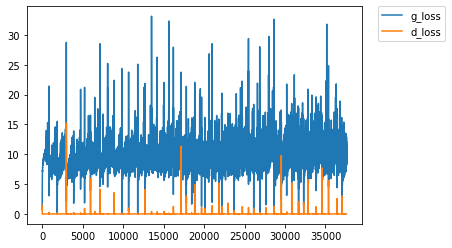

In [13]:
plt.plot(g_losses, label='g_loss')
plt.plot(d_losses, label='d_loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### 4-2-3. Visualize Generated Fake Images

(3, 242, 242)


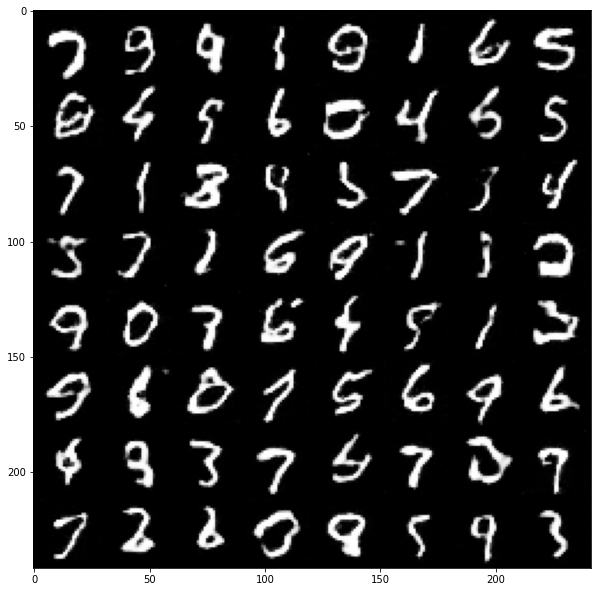

In [14]:
z = torch.randn(64, latent_dim, 1, 1).to(device)
imshow_grid(G(z))

# 5. Encoder

In [15]:
writer = SummaryWriter(logdir='runs/Encoder_training')

E = Encoder(latent_dim, ndf, channels, bias=True).to(device)

G.eval()
D.eval()

criterion = nn.MSELoss()

optimizer_E = torch.optim.Adam(E.parameters(), lr=lr, betas=(0.0, 0.999))

padding_epoch = len(str(n_epochs))
padding_i = len(str(len(train_dataloader)))
kappa = 1.0
e_losses = []

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(train_dataloader):
        real_imgs = imgs.to(device)
        
        optimizer_E.zero_grad() 
        z = E(real_imgs)
        
        fake_imgs = G(z)

        real_features = D.forward_features(real_imgs)
        fake_features = D.forward_features(fake_imgs)
        # real_feature = real_features / real_features.max()
        # fake_features = fake_features / fake_features.max()

        # izif architecture
        loss_imgs = criterion(fake_imgs, real_imgs)
        loss_features = criterion(fake_features, real_features)
        e_loss = loss_imgs + kappa * loss_features

        e_loss.backward()
        optimizer_E.step()


        if i % n_critic == 0:
            e_losses.append(e_loss)

            writer.add_scalar('e_loss', e_loss.item(), epoch)
            print(f"[Epoch {epoch:{padding_epoch}}/{n_epochs}] "
                    f"[Batch {i:{padding_i}}/{len(train_dataloader)}] "
                    f"[E loss: {e_loss.item():3f}]")
            
#writer.close()
print('Finished Training')

[Epoch   0/200] [Batch   0/938] [E loss: 1.138064]
[Epoch   0/200] [Batch   5/938] [E loss: 0.753701]
[Epoch   0/200] [Batch  10/938] [E loss: 0.649495]
[Epoch   0/200] [Batch  15/938] [E loss: 0.678364]
[Epoch   0/200] [Batch  20/938] [E loss: 0.663924]
[Epoch   0/200] [Batch  25/938] [E loss: 0.650092]
[Epoch   0/200] [Batch  30/938] [E loss: 0.602798]
[Epoch   0/200] [Batch  35/938] [E loss: 0.527358]
[Epoch   0/200] [Batch  40/938] [E loss: 0.528316]
[Epoch   0/200] [Batch  45/938] [E loss: 0.459769]
[Epoch   0/200] [Batch  50/938] [E loss: 0.458664]
[Epoch   0/200] [Batch  55/938] [E loss: 0.539401]
[Epoch   0/200] [Batch  60/938] [E loss: 0.458262]
[Epoch   0/200] [Batch  65/938] [E loss: 0.426167]
[Epoch   0/200] [Batch  70/938] [E loss: 0.444778]
[Epoch   0/200] [Batch  75/938] [E loss: 0.396432]
[Epoch   0/200] [Batch  80/938] [E loss: 0.391679]
[Epoch   0/200] [Batch  85/938] [E loss: 0.385055]
[Epoch   0/200] [Batch  90/938] [E loss: 0.392537]
[Epoch   0/200] [Batch  95/938]

## 5-1. Visualize the Learned Inverse Mapping

(3, 242, 242)


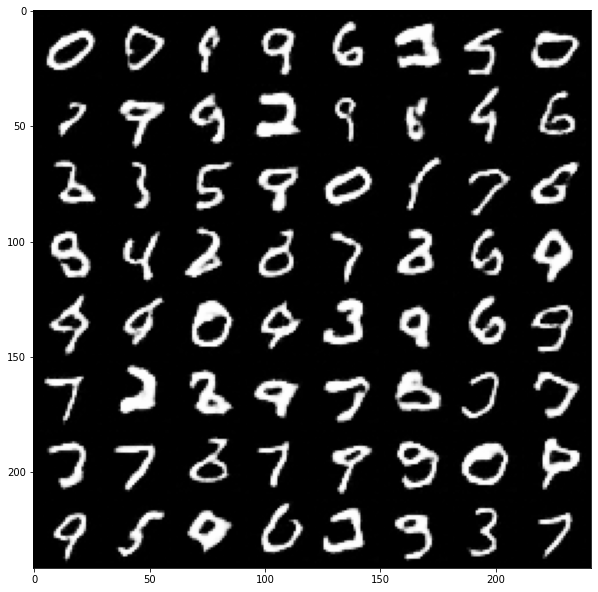

In [16]:
z = torch.randn(64, latent_dim, 1, 1).to(device) # 64, 100
fake_imgs = G(z) # 64, 1, 28, 28
fake_z = E(fake_imgs) #64, 100
reconfiguration_imgs = G(fake_z)

imshow_grid(reconfiguration_imgs)

# 6. Testing

## 6-1. Load Test Data

In [17]:
# Test DAta
test_dataset = MNIST('./', train=False, download=False)

#x_test = torch.cat([x_test_normal[:10], train_dataset.data[train_dataset.targets != 1], test_dataset.data], dim=0)[:20]
#y_test = torch.cat([y_test_normal[:10], train_dataset.targets[train_dataset.targets != 1], test_dataset.targets], dim=0)[:20]

list2 = [x for x in range(0, 784)]
x_test = test_dataset.data   
y_test = test_dataset.targets

test_mnist = SimpleDataset(x_test, y_test,
                            transform=transforms.Compose(
                            [transforms.ToPILImage(),
                            transforms.ToTensor(),
                            ])
                            )

test_dataloader = DataLoader(test_mnist, batch_size=1, shuffle=True)

In [19]:
def compare_images(real_img, generated_img, i, score, reverse=False, threshold=50):
    real_img = real_img.cpu().data.numpy().reshape(28, 28) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(28, 28) * 255

    #print(real_img)
    
    negative = np.zeros_like(real_img)

    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img
        
    #print(abs(diff_img))
    
    diff_img[abs(diff_img) <= threshold] = 0

    anomaly_img = np.zeros(shape=(28, 28, 3))
    anomaly_img[:, :, 0] = real_img #- diff_img
    anomaly_img[:, :, 1] = real_img #- diff_img
    anomaly_img[:, :, 2] = real_img #- diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + abs(diff_img)
    anomaly_img = anomaly_img.astype(np.uint8)

    fig, plots = plt.subplots(1, 4)
    fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label='real')
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')
    plt.show()

0


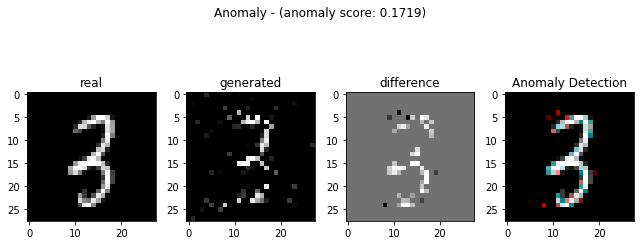

2000


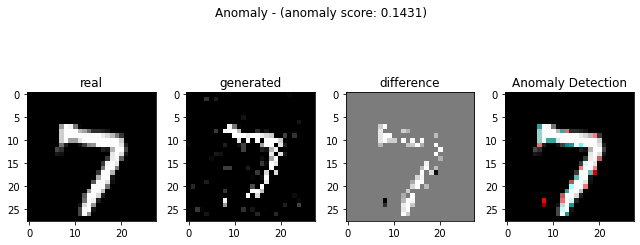

4000


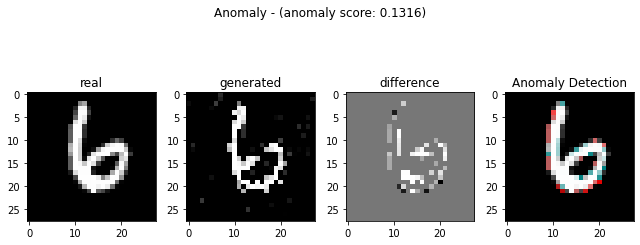

6000


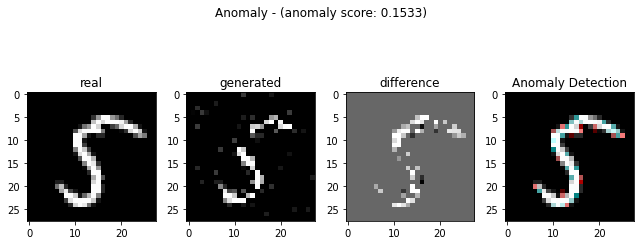

8000


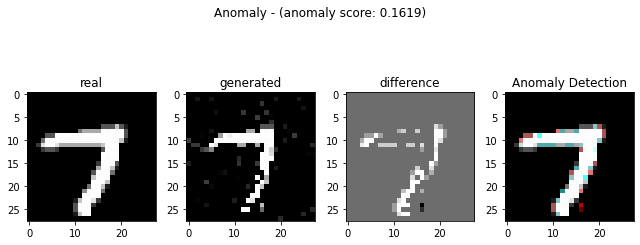

In [160]:
criterion = nn.MSELoss()
G.eval()
D.eval()
E.eval()

with open("score.csv", "w") as f:
        f.write("label,img_distance,anomaly_score,z_distance\n")

true_positive = 0
false_positive = 0
true_negative = 0
false_negative = 0

masked_data = []

for i, (img, label) in enumerate(test_dataloader):
    real_img = img.to(device)
    real_img_copy = real_img.clone().detach()
    
    list3 = random.sample(list2, 784//5)
    for k in list3:
        temp = random.uniform(0.0, 1.0)
        real_img[0][0][k//28][k%28] = temp       

    real_z = E(real_img)
    fake_img = G(real_z)
    fake_z = E(fake_img)

    real_feature = D.forward_features(real_img) # 1, 256
    fake_feature = D.forward_features(fake_img)
    real_feature = real_feature / real_feature.max()
    fake_feature = fake_feature / fake_feature.max()
    # print("real_feature max : ",real_feature.max())
    # print("real_feature min : ",real_feature.min())
    # print("fake_feature max : ",fake_feature.max())
    # print("fake_feature min : ",fake_feature.min())

    img_distance = criterion(fake_img, real_img)
    loss_feature = criterion(fake_feature, real_feature)

    anomaly_score = img_distance + kappa*loss_feature

    z_distance = criterion(fake_z, real_z)
    
    with open("score.csv", "a") as f:
            f.write(f"{label.item()},{img_distance},"
                    f"{anomaly_score},{z_distance}\n")
    
    
    diff_img = abs(real_img - fake_img)
    diff_img[diff_img > 0.25] = 2
    diff_img[diff_img <= 0.25] = 1
    real_diff_img = abs(real_img - real_img_copy)
    real_diff_img[real_diff_img > 0.25] = 3
    real_diff_img[real_diff_img <= 0.25] = 5
    
    assess = abs(real_diff_img - diff_img)
    true_positive += (assess == 1.).sum()
    false_negative += (assess == 2.).sum()
    false_positive += (assess == 3.).sum()
    true_negative += (assess == 4.).sum()
    
    diff_img = abs(real_img - fake_img)
    diff_img[diff_img > 0.25] = 1
    diff_img[diff_img <= 0.25] = 0
    mask_ = abs(diff_img - 1)
    denoised_img_ = real_img * mask_
    #print(denoised_img.type)
    denoised_img = denoised_img_.cpu().data.numpy().reshape(28, 28) #* 255
    #print(type(denoised_img))
    masked_data.append((denoised_img, mask_.cpu().data.numpy().reshape(28, 28), real_img_copy.cpu().data.numpy().reshape(28, 28), real_img.cpu().data.numpy().reshape(28, 28)))
    #print(mask_)
    
    if i % 2000 == 0:
        print(i)
        #print("real: ", real_diff_img)
        #print("estimate: ", diff_img)
        #print(assess)
    
        #print(f"{label.item()}, {img_distance}, "
        #  f"{anomaly_score}, {z_distance}\n")
        
        compare_images(real_img_copy, denoised_img_,i, anomaly_score, reverse = False, threshold = 80)
        #print(abs(real_img - fake_img) * 255)
        #print(real_img - real_img_copy)
    



In [161]:
accuracy = (true_positive.item() + true_negative.item())/(true_positive.item() + true_negative.item() + false_positive.item() + false_negative.item())
precision = true_positive.item() / (true_positive.item() + false_positive.item())
recall = true_positive.item() / (true_positive.item() + false_negative.item())
f1 = 2 * (precision * recall) / (precision + recall)
specificity = true_negative.item() / (false_positive.item() + true_negative.item())
print(accuracy, precision, recall, f1, specificity)

0.8930280612244897 0.5824134652683016 0.9280229862218068 0.7156780183911227 0.8870897259177489


# 7. GAIN

## 7-1. Import Libraries

In [25]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm_notebook as tqdm

import torch
import torch.nn.functional as F
import tensorflow as tf
old_v = tf.compat.v1.logging.get_verbosity()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from input_data import read_data_sets
# from tensorflow.examples.tutorials.mnist import input_data
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## 7-2. Initialize Parameters

In [26]:
use_gpu = torch.cuda.is_available()

In [27]:
def init_params(mb_size=128, p_miss=0.2, p_hint=0.9, alpha=10, 
                Train_No=60000, Test_No=10000, 
                Dim=784, H_Dim1=256, H_Dim2=128, 
                learning_rate=0.001, epochs=10000): 
    
    # Mini batch size
    mb_size = mb_size
    # Missing rate
    p_miss = p_miss
    # Hint rate
    p_hint = p_hint
    # Loss Hyperparameters
    alpha = alpha
    
    # No
    Train_No = Train_No
    Test_No = Test_No
    
    # Input dimension (Fixed)
    Dim = Dim
    # Hidden state dimensions
    H_Dim1 = H_Dim1
    H_Dim2 = H_Dim2
    
    # Learning Rate
    learning_rate = learning_rate
    # Epochs
    epochs = epochs
    
    return mb_size, p_miss, p_hint, alpha, Dim, H_Dim1, H_Dim2, Train_No, Test_No, learning_rate, epochs

In [28]:
mb_size, p_miss, p_hint, alpha, Dim, H_Dim1, H_Dim2, Train_No, Test_No, learning_rate, epochs = init_params()

## 7-3. GAIN Model Architecture

In [29]:
class NetD(torch.nn.Module):
    def __init__(self):
        super(NetD, self).__init__()
        self.fc1 = torch.nn.Linear(Dim * 2, H_Dim1)
        self.fc2 = torch.nn.Linear(H_Dim1, H_Dim2)
        self.fc3 = torch.nn.Linear(H_Dim2, Dim)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.init_weight()

    def init_weight(self):
        layers = [self.fc1, self.fc2, self.fc3]
        [torch.nn.init.xavier_normal_(layer.weight) for layer in layers]

    def forward(self, x, h):
        inp = torch.cat((x, h), dim=1)
        out = self.relu(self.fc1(inp))
        out = self.relu(self.fc2(out))
        out = self.sigmoid(self.fc3(out)) # [0,1] Probability Output
        return out

    
class NetG(torch.nn.Module):
    def __init__(self):
        super(NetG, self).__init__()
        self.fc1 = torch.nn.Linear(Dim * 2, H_Dim1)
        self.fc2 = torch.nn.Linear(H_Dim1, H_Dim2)
        self.fc3 = torch.nn.Linear(H_Dim2, Dim)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.init_weight()

    def init_weight(self):
        layers = [self.fc1, self.fc2, self.fc3]
        [torch.nn.init.xavier_normal_(layer.weight) for layer in layers]

    def forward(self, x, m):
        inp = torch.cat((x, m), dim=1)
        out = self.relu(self.fc1(inp))
        out = self.relu(self.fc2(out))
        out = self.sigmoid(self.fc3(out))  # [0,1] Probability Output
        return out

## 7-4. Mask Vector and Hint Vector Generation

In [30]:
def sample_M(m, n, p):
    A = np.random.uniform(0., 1., size=[m, n])
    B = A > p
    C = 1. * B
    return C


# Random sample generator for Z
def sample_Z(m, n, high):
    return np.random.uniform(0., high, size=[m, n])


# Mini-batch generation
def sample_idx(m, n):
    A = np.random.permutation(m)
    idx = A[:n]
    return idx

## 7-5. Define Loss Functions

In [31]:
def discriminator_loss(netG, netD, M, X, H): 
    # Generator
    G_sample = netG(X, M)
    # Combine with original data
    Hat_New_X = X * M + G_sample * (1-M)
    # Discriminator
    D_prob = netD(Hat_New_X, H)
    # Loss
    D_loss = -torch.mean(M * torch.log(D_prob + 1e-8) + (1-M) * torch.log(1. - D_prob + 1e-8))
    return D_loss


def generator_loss(netG, netD, X, M, New_X, H):
    # %% Structure
    # Generator
    G_sample = netG(New_X, M)
    # Combine with original data
    Hat_New_X = New_X * M + G_sample * (1-M)
    # Discriminator
    D_prob = netD(Hat_New_X, H)

    # Loss
    G_loss1 = -torch.mean((1-M) * torch.log(D_prob + 1e-8))
    MSE_train_loss = torch.mean((M * New_X - M * G_sample)**2) / torch.mean(M)
    G_loss = G_loss1 + alpha * MSE_train_loss 

    # MSE Performance metric
    MSE_test_loss = torch.mean(((1-M) * X - (1-M)*G_sample)**2) / torch.mean(1-M)
    return G_loss, MSE_train_loss, MSE_test_loss


def test_loss(netG, netD, X, M, New_X):
    # %% Structure
    # Generator
    G_sample = netG(New_X, M)

    # MSE Performance metric
    MSE_test_loss = torch.mean(((1-M) * X - (1-M)*G_sample)**2) / torch.mean(1-M)
    return MSE_test_loss, G_sample

In [32]:
def plot(samples):
    fig = plt.figure(figsize=(5, 5))
    gs = gridspec.GridSpec(5, 5)
    gs.update(wspace=0.05, hspace=0.05)
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
    return fig


def outputFigure(it, netG, Test_No, mb_idx, Dim, high):
    mb_idx = sample_idx(Test_No, 5)
    X_mb = testX[mb_idx, :]
    M_mb = testM[mb_idx, :]
    Z_mb = sample_Z(5, Dim, high)

    New_X_mb = M_mb * X_mb + (1 - M_mb) * Z_mb

    if use_gpu is True:
        X_mb = torch.tensor(X_mb, device='cuda').float()
        M_mb = torch.tensor(M_mb, device='cuda').float()
        New_X_mb = torch.tensor(New_X_mb, device='cuda').float()
        Z_mb = torch.tensor(Z_mb, device='cuda').float()
    else:
        X_mb = torch.tensor(X_mb).float()
        M_mb = torch.tensor(M_mb).float()
        New_X_mb = torch.tensor(New_X_mb).float()
        Z_mb = torch.tensor(Z_mb).float()

    samples1 = X_mb
    samples5 = M_mb * X_mb + (1 - M_mb) * Z_mb
    inp = M_mb * X_mb + (1-M_mb) * New_X_mb
    samples2 = netG(inp, M_mb)
    samples2 = M_mb * X_mb + (1 - M_mb) * samples2

    Z_mb = sample_Z(5, Dim, high)
    if use_gpu is True:
        Z_mb = torch.tensor(Z_mb, device='cuda').float()
    else:
        Z_mb = torch.tensor(Z_mb).float()
    New_X_mb = M_mb * X_mb + (1 - M_mb) * Z_mb

    inp = M_mb * X_mb + (1-M_mb) * New_X_mb
    samples3 = netG(inp, M_mb)
    samples3 = M_mb * X_mb + (1 - M_mb) * samples3

    Z_mb = sample_Z(5, Dim, high)
    if use_gpu is True:
        Z_mb = torch.tensor(Z_mb, device='cuda').float()
    else:
        Z_mb = torch.tensor(Z_mb).float()
    New_X_mb = M_mb * X_mb + (1 - M_mb) * Z_mb
    inp = M_mb * X_mb + (1-M_mb) * New_X_mb
    samples4 = netG(inp, M_mb)
    samples4 = M_mb * X_mb + (1 - M_mb) * samples4

    if use_gpu is True:
        samples = np.vstack([samples5.cpu().detach().data, samples2.cpu().detach().data, 
                             samples3.cpu().detach().data, samples4.cpu().detach().data, 
                             samples1.cpu().detach().data])
    else:
        samples = np.vstack([samples5.detach().data, samples2.detach().data, 
                             samples3.detach().data, samples4.detach().data, 
                             samples1.detach().data])
    fig = plot(samples)
    plt.savefig('Multiple_Impute/{}.png'.format(str(it).zfill(3)), bbox_inches='tight')
    plt.close(fig)

## 7-6. GAIN Training and Testing Functions

In [68]:
def trainGAIN(netG, netD, Dim, trainX, trainM, optimG, optimD, alpha=alpha, epochs=epochs, 
              high=0.01, printLoss=True, outFigure=True):
    # %% Output Initialization
    if outFigure==True:    
        if not os.path.exists('Multiple_Impute/'):
            os.makedirs('Multiple_Impute/')
    
    # %% Start Iterations
    for it in tqdm(range(epochs)):
        # %% Inputs
        mb_idx = sample_idx(Train_No, mb_size) 
        X_mb = trainX[mb_idx,:]  
        Z_mb = sample_Z(mb_size, Dim, high) 

        M_mb = trainM[mb_idx, :]     
        H_mb1 = sample_M(mb_size, Dim, 1-p_hint) 
        H_mb = M_mb * H_mb1  
        # H_mb = M_mb * H_mb1 + 0.5 * (1 - H_mb1)

        New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  # Missing Data Introduce 

        if use_gpu is True:
            X_mb = torch.tensor(X_mb, device='cuda').float()
            M_mb = torch.tensor(M_mb, device='cuda').float()
            H_mb = torch.tensor(H_mb, device='cuda').float()
            New_X_mb = torch.tensor(New_X_mb, device='cuda').float()
            Z_mb = torch.tensor(Z_mb, device='cuda').float()
        else:
            X_mb = torch.tensor(X_mb).float()
            M_mb = torch.tensor(M_mb).float()
            H_mb = torch.tensor(H_mb).float()
            New_X_mb = torch.tensor(New_X_mb).float()
            Z_mb = torch.tensor(Z_mb).float()

        # Train Discriminator
        optimD.zero_grad() 
        D_loss = discriminator_loss(netG, netD, M=M_mb, X=New_X_mb, H=H_mb)
        D_loss.backward()
        optimD.step()

        # Train Generator
        optimG.zero_grad() 
        G_loss, G_mse_loss, G_mse_test = generator_loss(netG, netD, X=X_mb, M=M_mb, New_X=New_X_mb, H=H_mb)
        G_loss.backward()
        optimG.step()
       
        if it % 100 == 0:
            # %% Intermediate Losses
            if printLoss==True:
                print('Iter: {}'.format(it),end='\t')
                print('Train_loss: {:.4}'.format(G_mse_loss),end='\t')
                print('Test_loss: {:.4}'.format(G_mse_test),end='\t')
                print('D_loss: {:.4}'.format(D_loss))
            
            # %% Output figure
            if outFigure==True:
                outputFigure(it, netG, Test_No, mb_idx, Dim, high) 
            

def testGAIN(netG, netD, Dim, testM, testX, high=0.01):
    Z_mb = sample_Z(Test_No, Dim, high) 
    M_mb = testM 
    X_mb = testX
    New_X_mb = M_mb * X_mb + (1-M_mb) * Z_mb  

    # make the tensors
    if use_gpu is True:
        X_mb = torch.tensor(X_mb, device='cuda').float()
        M_mb = torch.tensor(M_mb, device='cuda').float()
        New_X_mb = torch.tensor(New_X_mb, device='cuda').float()
    else:
        X_mb = torch.tensor(X_mb).float()
        M_mb = torch.tensor(M_mb).float()
        New_X_mb = torch.tensor(New_X_mb).float()

    MSE_final, Sample = test_loss(netG, netD, X=X_mb, M=M_mb, New_X=New_X_mb)
    #print('Test RMSE: ' + str(np.sqrt(MSE_final.item())))
    print()
    
    return Sample, New_X_mb

In [34]:
def plotBeforeAfter(New_X_mb, imputed_x, plot_name1, plot_name2):
    if not os.path.exists('images/'):
        os.makedirs('images/')
    
    # Plot images before Imputation
    fig, axes = plt.subplots(10,10, figsize=(8,8))
    for i,ax in enumerate(axes.flat):
        if use_gpu is True:
            ax.imshow(New_X_mb[i].cpu().reshape(28,28))
        else:
            ax.imshow(New_X_mb[i].reshape(28,28))
    fig.savefig('images/' + plot_name1)
    
    # Plot images after Imputation
    fig, axes = plt.subplots(10,10, figsize=(8,8))
    for i,ax in enumerate(axes.flat):
        if use_gpu is True:
            ax.imshow(imputed_x[i].cpu().detach().numpy().reshape(28,28))
        else:
            ax.imshow(imputed_x[i].detach().numpy().reshape(28,28))
    fig.savefig('images/' + plot_name2)

In [35]:
mnist = read_data_sets('./MNIST_data', one_hot = True)
tf.compat.v1.logging.set_verbosity(old_v)

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


## 7-7. Load Corrupt Test Data and Dirty Vectors

In [162]:
#print(masked_data[0][0].reshape(784))
testX = []
testM = []
clean_testX = []
corrupted_testX = []
for i in range(len(masked_data)):
    testX.append(masked_data[i][0].reshape(784))
    testM.append(masked_data[i][1].reshape(784))
    clean_testX.append(masked_data[i][2].reshape(784))
    corrupted_testX.append(masked_data[i][3].reshape(784))

In [163]:
testX = np.array(testX)
testM = np.array(testM)

## 7-8. Load Training Data and Generate Training Mask Vector

In [ ]:
# Train / Test Features
trainX, _ = mnist.train.next_batch(Train_No)
#testX, _ = mnist.test.next_batch(Test_No)

# Train / Test Missing Indicators
trainM = sample_M(Train_No, Dim, p_miss)
#testM = sample_M(Test_No, Dim, p_miss)

In [77]:
"""
# Plot original images 
fig, axes = plt.subplots(10,10, figsize=(8,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(testX[i].reshape(28,28))

if not os.path.exists('images/'):
    os.makedirs('images/')
fig.savefig('images/' + 'original')
"""

"\n# Plot original images \nfig, axes = plt.subplots(10,10, figsize=(8,8))\nfor i,ax in enumerate(axes.flat):\n    ax.imshow(testX[i].reshape(28,28))\n\nif not os.path.exists('images/'):\n    os.makedirs('images/')\nfig.savefig('images/' + 'original')\n"

## 7-9. Train GAIN

In [41]:
# %% Init Network 
if use_gpu is True:
    netD = NetD().cuda()
    netG = NetG().cuda()
else:
    netD = NetD()
    netG = NetG()

# Optimizers
optimD = torch.optim.Adam(netD.parameters(), lr=learning_rate)
optimG = torch.optim.Adam(netG.parameters(), lr=learning_rate)


In [42]:
trainGAIN(netG, netD, Dim, trainX, trainM, optimG, optimD, alpha=alpha, epochs=epochs, high=1.)

  0%|          | 0/10000 [00:00<?, ?it/s]

Iter: 0	Train_loss: 0.2351	Test_loss: 0.2347	D_loss: 0.7025
Iter: 100	Train_loss: 0.04887	Test_loss: 0.05149	D_loss: 0.4998
Iter: 200	Train_loss: 0.03452	Test_loss: 0.03749	D_loss: 0.4978
Iter: 300	Train_loss: 0.02677	Test_loss: 0.02962	D_loss: 0.494
Iter: 400	Train_loss: 0.02269	Test_loss: 0.02773	D_loss: 0.4902
Iter: 500	Train_loss: 0.02135	Test_loss: 0.02577	D_loss: 0.4935
Iter: 600	Train_loss: 0.01886	Test_loss: 0.0242	D_loss: 0.4866
Iter: 700	Train_loss: 0.01821	Test_loss: 0.02356	D_loss: 0.4833
Iter: 800	Train_loss: 0.016	Test_loss: 0.02172	D_loss: 0.4835
Iter: 900	Train_loss: 0.01549	Test_loss: 0.02034	D_loss: 0.4832
Iter: 1000	Train_loss: 0.01358	Test_loss: 0.01898	D_loss: 0.4808
Iter: 1100	Train_loss: 0.01406	Test_loss: 0.02049	D_loss: 0.4808
Iter: 1200	Train_loss: 0.01204	Test_loss: 0.01842	D_loss: 0.4824
Iter: 1300	Train_loss: 0.01295	Test_loss: 0.01991	D_loss: 0.4793
Iter: 1400	Train_loss: 0.01209	Test_loss: 0.01864	D_loss: 0.4794
Iter: 1500	Train_loss: 0.01203	Test_loss: 0

## 7-10. Test GAIN with Corrupt Data

In [164]:

# %% Testing
imputed_x, New_X_mb = testGAIN(netG, netD, Dim, testM, testX, high=1.)
dif = abs(imputed_x.cpu().data.numpy() - clean_testX)
rmse_imputed = np.sum(np.sqrt(np.sum(np.square(dif), axis=1)/784))/10000
std_imputed = np.std(np.sqrt(np.sum(np.square(dif), axis=1)/784))
dif_2 = abs(np.array(corrupted_testX) - clean_testX)
rmse_dirty = np.sum(np.sqrt(np.sum(np.square(dif_2), axis=1)/784))/10000
std_corrupted = np.std(np.sqrt(np.sum(np.square(dif_2), axis=1)/784))

print("Corrected RMSE: ", rmse_imputed, "Corrected STD: ", std_imputed)
print("Corrupted RMSE: ", rmse_dirty, "Corrected STD: ", std_corrupted)

print("Imputed Data Shape:", imputed_x.shape)

Test RMSE: 0.40372504000676845

Corrected RMSE:  0.1512542236328125 Corrected STD:  0.03087784
Corrupted RMSE:  0.2500656005859375 Corrected STD:  0.009565152
Imputed Data Shape: torch.Size([10000, 784])


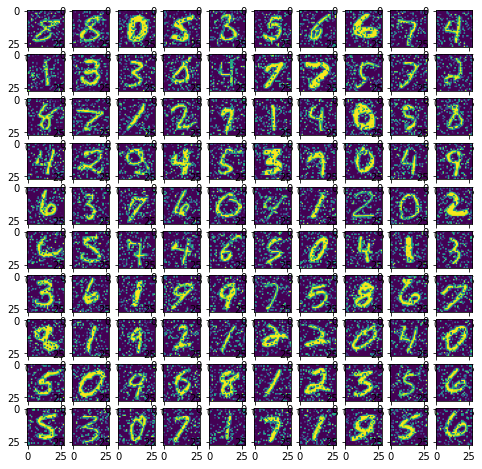

In [44]:
# Plot original images 
fig, axes = plt.subplots(10,10, figsize=(8,8))
cor = np.array(corrupted_testX)
for i,ax in enumerate(axes.flat):
    ax.imshow(cor[i].reshape(28,28))

if not os.path.exists('images/'):
    os.makedirs('images/')
fig.savefig('images/' + 'corrupted')

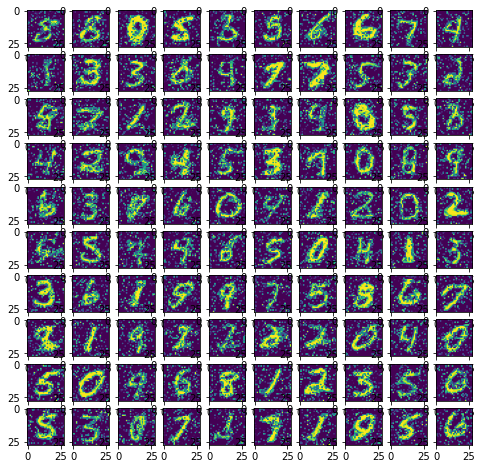

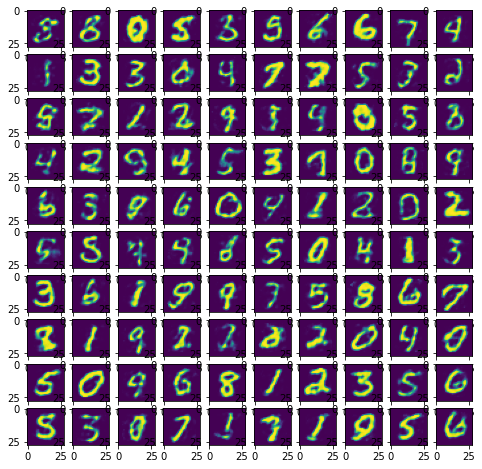

In [47]:
plotBeforeAfter(New_X_mb, imputed_x, 'noise_gain_fast_50.png', 'imputed_gain_fast_50.png')